In [117]:
import os

# Prepend Homebrew binaries to PATH for subprocess
os.environ["PATH"] = "/opt/homebrew/bin:" + os.environ.get("PATH", "")

# Optional: check it worked
!which fluidsynth

/opt/homebrew/bin/fluidsynth


## Preprocessing

### Tempo normalization + Synthesize MIDI + Split data 

Synthesize MIDI files to audio with tempo normalization and create train/test splits.
Normalizes all MIDI to 120 BPM, synthesizes to audio, verifies with librosa, and filters.


In [118]:
import pretty_midi
import librosa
import numpy as np
from pathlib import Path
import json
from tqdm import tqdm
import subprocess
import shutil
from IPython.display import Audio
import random

# Paths
MIDI_DIR = Path("./datasets/PPDD-Jul2018_aud_mono_small/prime_midi")
CONTINUATION_DIR = Path("./datasets/PPDD-Jul2018_aud_mono_small/cont_true_midi")

OUTPUT_BASE = Path("./normalized_dataset")
TRAIN_DIR = OUTPUT_BASE / "train"
TEST_DIR = OUTPUT_BASE / "test"

# Create directories
TRAIN_DIR.mkdir(parents=True, exist_ok=True)
TEST_DIR.mkdir(parents=True, exist_ok=True)


In [119]:

def normalize_midi_tempo(midi_file_path, target_bpm=120.0):
    """
    Normalize MIDI file to target BPM by scaling note timings.

    Args:
        midi_file_path: Path to MIDI file
        target_bpm: Target tempo in BPM

    Returns:
        pretty_midi.PrettyMIDI object with normalized tempo
    """
    midi = pretty_midi.PrettyMIDI(midi_file_path)

    # Get original tempo
    original_bpm = midi.get_tempo_changes()[1][0]
    tempo_ratio = target_bpm / original_bpm

    # Scale note timings
    for instrument in midi.instruments:
        for note in instrument.notes:
            note.start *= tempo_ratio
            note.end *= tempo_ratio
        for cc in instrument.control_changes:
            cc.time *= tempo_ratio
        for pb in instrument.pitch_bends:
            pb.time *= tempo_ratio

        # Reset to program 0 (piano)
        if not instrument.is_drum:
            instrument.program = 0
            instrument.channel = 0

    # Set constant tempo
    midi._tempo_changes = ([0.0], [target_bpm])

    return midi


def synthesize_midi(midi_file_path, output_audio_path, soundfont_path):
    """
    Synthesize MIDI to audio using FluidSynth.

    Args:
        midi_file_path: Path to MIDI file
        output_audio_path: Path to save audio
        soundfont_path: Path to soundfont

    Returns:
        True if successful
    """
    try:
        cmd = [
            "fluidsynth",
            "-ni",
            "-g", "3.0", # increase gain to match the volume of the original wav file
            "-r", "22050",  # Sample rate to match spectrogram extraction
            "-F", str(output_audio_path),
            str(soundfont_path),
            str(midi_file_path)
        ]
        result = subprocess.run(cmd, capture_output=True, timeout=60)
        return result.returncode == 0
    except Exception as e:
        print(f"    Error synthesizing: {e}")
        return False


def verify_tempo(audio_path, sr=22050, target_bpm=120.0, tolerance=5.0):
    """
    Verify audio tempo using librosa, accepting tempo octaves.

    Args:
        audio_path: Path to audio file
        sr: Sample rate
        target_bpm: Expected BPM
        tolerance: Allowed deviation in BPM (default ±5)

    Returns:
        Tuple of (is_valid, detected_bpm)
    """
    try:
        y, _ = librosa.load(audio_path, sr=sr)
        detected_bpm = librosa.feature.tempo(y=y, sr=sr)[0]

        # Check if detected BPM matches target or tempo octaves (x0.5, x2)
        octave_bpms = [target_bpm / 2, target_bpm, target_bpm * 2]
        is_valid = any(abs(detected_bpm - bpm) <= tolerance for bpm in octave_bpms)

        return is_valid, detected_bpm
    except Exception as e:
        return False, None

def find_soundfont():
    """Find available FluidSynth soundfont."""
    paths = "./UprightPianoKW-small-20190703.sf2"

    return paths




In [120]:
import soundfile as sf

# ========================
# Test Tempo Normalization
# ========================

# Normalize MIDI
midi_file = "./tests/0ef0042b-f34a-4fa0-9acf-261159083e2b.mid"
print("normalizing midi")
normalized_midi = normalize_midi_tempo(str(midi_file), 120)

# Save normalized MIDI
print("saving midi")
temp_midi_path = f"./tests/normalized.mid"
normalized_midi.write(str(temp_midi_path))

# Synthesize to audio
print("synthesizing midi")
synthesize_midi(str(temp_midi_path), str('./tests/normalized.wav'), "./UprightPianoKW-small-20190703.sf2")
# # trim trailing silence
# y, sr = librosa.load('./tests/normalized.wav', sr=22050)
# y_trimmed, _ = librosa.effects.trim(y, top_db=20)
# # Save trimmed audio
# sf.write('./tests/normalized.wav', y_trimmed, sr)


normalizing midi
saving midi
synthesizing midi


True

In [121]:

def process_dataset(target_bpm=120.0):
    """
    Process all MIDI files: normalize, synthesize, verify, and split.

    Args:
        target_bpm: Target tempo for normalization

    Returns:
        Dictionary with dataset info
    """
    # Find soundfont
    soundfont = find_soundfont()
    if not soundfont:
        print("ERROR: FluidSynth soundfont not found!")
        return None
    print(f"Using soundfont: {soundfont}\n")

    # Get all MIDI files
    midi_files = sorted(list(MIDI_DIR.glob('*.mid')) + list(MIDI_DIR.glob('*.midi')))
    continuation_files = {f.stem: f for f in list(CONTINUATION_DIR.glob('*.mid')) + list(CONTINUATION_DIR.glob('*.midi'))} if CONTINUATION_DIR.exists() else {}

    print(f"Found {len(midi_files)} MIDI files")
    print(f"Found {len(continuation_files)} continuation files\n")

    # Process each MIDI file
    stats = {
        'total': len(midi_files),
        'synthesized': 0,
        'verified': 0,
        'failed': 0,
        'bpms': [],
        'failed_files': [],
        'train_files': [],
        'test_files': []
    }

    temp_midi_dir = OUTPUT_BASE / "temp_normalized_midi"
    temp_midi_dir.mkdir(exist_ok=True)

    print("=" * 70)
    print("STEP 1: Normalize and synthesize MIDI files")
    print("=" * 70)

    valid_pairs = []  # (name, midi_path, audio_path)

    for i, midi_file in enumerate(tqdm(midi_files, desc="Processing", unit="file")):
        name = midi_file.stem

        try:
            # Normalize MIDI
            normalized_midi = normalize_midi_tempo(str(midi_file), target_bpm)

            # Save normalized MIDI
            temp_midi_path = temp_midi_dir / f"{name}_normalized.mid"
            normalized_midi.write(str(temp_midi_path))

            # Synthesize to audio
            audio_path = OUTPUT_BASE / f"{name}.wav"
            if synthesize_midi(str(temp_midi_path), str(audio_path), soundfont):
                stats['synthesized'] += 1
                # # trim trailing silence
                # y, sr = librosa.load(audio_path, sr=22050)
                # y_trimmed, _ = librosa.effects.trim(y, top_db=20)
                # sf.write(audio_path, y_trimmed, sr)

                # Verify tempo
                is_valid, detected_bpm = verify_tempo(str(audio_path), target_bpm=target_bpm)

                if is_valid:
                    stats['verified'] += 1
                    stats['bpms'].append(detected_bpm)
                    valid_pairs.append((name, str(midi_file), str(audio_path)))
                else:
                    stats['failed'] += 1
                    stats['failed_files'].append(f"{name} (detected: {detected_bpm:.1f} BPM)")
            else:
                stats['failed'] += 1
                stats['failed_files'].append(f"{name} (synthesis failed)")

        except Exception as e:
            stats['failed'] += 1
            stats['failed_files'].append(f"{name} ({str(e)})")

    print("\n" + "=" * 70)
    print("STEP 2: Split into train/test (80/20)")
    print("=" * 70)

    # Split 80/20
    random.shuffle(valid_pairs)
    n_train = int(len(valid_pairs) * 0.8)
    train_pairs = valid_pairs[:n_train]
    test_pairs = valid_pairs[n_train:]

    print(f"Train set: {len(train_pairs)} files")
    print(f"Test set: {len(test_pairs)} files\n")

    # Copy train files
    print("Copying training files...")
    for name, midi_path, audio_path in tqdm(train_pairs, desc="Train", unit="file"):
        shutil.copy(audio_path, TRAIN_DIR / f"{name}.wav")

        # Add continuation if available
        if name in continuation_files:
            cont_midi = continuation_files[name]
            cont_audio = TRAIN_DIR / f"{name}_continuation.wav"

            # # Normalize and synthesize continuation
            # try:
            #     normalized_cont = normalize_midi_tempo(str(cont_midi), target_bpm)
            #     temp_cont_midi = temp_midi_dir / f"{name}_continuation_normalized.mid"
            #     normalized_cont.write(str(temp_cont_midi))
            #     synthesize_midi(str(temp_cont_midi), str(cont_audio), soundfont)
            # except:
            #     pass

        stats['train_files'].append(name)

    # Copy test files
    print("Copying test files...")
    test_continuation_dir = TEST_DIR / "continuation_midi"
    test_continuation_dir.mkdir(exist_ok=True)

    for name, midi_path, audio_path in tqdm(test_pairs, desc="Test", unit="file"):
        shutil.copy(audio_path, TEST_DIR / f"{name}.wav")

        # Save normalized continuation MIDI if available (for evaluation ground truth)
        if name in continuation_files:
            cont_midi = continuation_files[name]
            cont_output = test_continuation_dir / f"{name}_continuation.mid"

            # Normalize and save continuation MIDI
            try:
                normalized_cont = normalize_midi_tempo(str(cont_midi), target_bpm)
                normalized_cont.write(str(cont_output))
            except Exception as e:
                print(f"    Warning: Could not process continuation for {name}: {e}")

        stats['test_files'].append(name)

    # Clean up temp directory
    shutil.rmtree(temp_midi_dir)

    # Print summary
    print("\n" + "=" * 70)
    print("SUMMARY")
    print("=" * 70)
    print(f"Files processed: {stats['synthesized']}")
    print(f"Files verified (120 BPM ±2): {stats['verified']}")
    print(f"Files failed: {stats['failed']}")

    if stats['bpms']:
        bpms = np.array(stats['bpms'])
        print(f"Mean detected BPM: {np.mean(bpms):.1f}")
        print(f"Std dev: {np.std(bpms):.2f}")

    if stats['failed_files']:
        print(f"\nFailed files ({len(stats['failed_files'])}):")
        for f in stats['failed_files'][:10]:
            print(f"  - {f}")
        if len(stats['failed_files']) > 10:
            print(f"  ... and {len(stats['failed_files']) - 10} more")

    print(f"\nDataset saved to: {OUTPUT_BASE}")
    print(f"  Train: {TRAIN_DIR} ({len(stats['train_files'])} files)")
    print(f"  Test: {TEST_DIR} ({len(stats['test_files'])} files)")

    # Save stats
    stats_file = OUTPUT_BASE / "dataset_stats.json"
    with open(stats_file, 'w') as f:
        json.dump({
            'total': stats['total'],
            'synthesized': stats['synthesized'],
            'verified': stats['verified'],
            'failed': stats['failed'],
            'mean_bpm': float(np.mean(stats['bpms'])) if stats['bpms'] else None,
            'std_bpm': float(np.std(stats['bpms'])) if stats['bpms'] else None,
            'train_count': len(stats['train_files']),
            'test_count': len(stats['test_files']),
            'failed_files': stats['failed_files']
        }, f, indent=2)

    print(f"\nStats saved to: {stats_file}")

    return stats


process_dataset(target_bpm=120.0)

Using soundfont: ./UprightPianoKW-small-20190703.sf2

Found 100 MIDI files
Found 100 continuation files

STEP 1: Normalize and synthesize MIDI files


Processing: 100%|██████████| 100/100 [00:17<00:00,  5.86file/s]



STEP 2: Split into train/test (80/20)
Train set: 60 files
Test set: 15 files

Copying training files...


Train: 100%|██████████| 60/60 [00:00<00:00, 641.76file/s]


Copying test files...


Test: 100%|██████████| 15/15 [00:00<00:00, 338.29file/s]


SUMMARY
Files processed: 100
Files verified (120 BPM ±2): 75
Files failed: 25
Mean detected BPM: 113.1
Std dev: 15.67

Failed files (25):
  - 0cdc1aa9-ae7e-4bf0-9f74-9b5b31f3f84b (detected: 80.7 BPM)
  - 126806ab-1258-436a-860e-7e53e04fac31 (detected: 80.7 BPM)
  - 1458c887-280e-4e11-9e34-9ecfb7e6970e (detected: 184.6 BPM)
  - 182fa8dd-1dd5-4d77-b22e-98d734236dc8 (detected: 172.3 BPM)
  - 2592ce2c-13b4-4fbf-8427-5076ac2adee6 (detected: 89.1 BPM)
  - 2dd27791-618c-4035-8486-32f25476dc40 (detected: 80.7 BPM)
  - 33d5a8c4-fd03-45d8-82b0-2a9d53e06752 (detected: 95.7 BPM)
  - 34adf640-04d3-4d6e-b61f-7c5e53e1ad59 (detected: 80.7 BPM)
  - 44690756-b437-4f5c-9860-bcce8f3e0a03 (detected: 95.7 BPM)
  - 46559eb2-3a8c-41da-b326-18029939a36e (detected: 80.7 BPM)
  ... and 15 more

Dataset saved to: normalized_dataset
  Train: normalized_dataset/train (60 files)
  Test: normalized_dataset/test (15 files)

Stats saved to: normalized_dataset/dataset_stats.json


{'total': 100,
 'synthesized': 100,
 'verified': 75,
 'failed': 25,
 'bpms': [np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(123.046875),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(60.09265988372093),
  np.float64(117.45383522727273),
  np.float64(117.45383522727273),
  np.float64(117.4

### Spectrogram Extraction

In [122]:
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def slice_waveform(y, sr=22050, slice_sec=0.125, n_fft=2048, hop_length=512, n_mels=128, pad=True):
    """
    Convert audio waveform into fixed-length Mel spectrogram slices.
    
    Args:
        y: audio waveform
        sr: sample rate
        slice_sec: duration of each slice in seconds
        n_fft, hop_length, n_mels: Mel spectrogram parameters
        pad: whether to pad last slice if shorter
    
    Returns:
        slices: list of (n_mels, frames_per_slice) arrays
    """
    # Full Mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    frames_per_slice = int(slice_sec * sr / hop_length)
    slices = []
    for start in range(0, S_db.shape[1], frames_per_slice):
        end = start + frames_per_slice
        slice_ = S_db[:, start:end]
        if pad and slice_.shape[1] < frames_per_slice:
            # continue
            pad_width = frames_per_slice - slice_.shape[1]
            slice_ = np.pad(slice_, ((0,0),(0,pad_width)), mode='constant')
        slices.append(slice_.astype(np.float32))
    
    return slices, S_db



def extract_spectrograms(audio_files, sr=22050, note_fraction=0.25, n_fft=2048, n_mels=128, pad=True, visualize=False):
    quarter_note_sec = 60 / 120.0
    slice_duration_sec = quarter_note_sec * note_fraction
    
    sequences = []
    hop_length = 512  # standard hop_length for mel spectrogram

    for idx, audio_path in enumerate(audio_files):
        y, _ = librosa.load(audio_path, sr=sr)
        slices, S_db = slice_waveform(y, sr=sr, slice_sec=slice_duration_sec,
                                      n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, pad=pad)
        sequences.append(slices)

        if visualize and idx == 0:
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
            plt.colorbar(format='%+2.0f dB')
            plt.title(f"Mel spectrogram: {audio_path.name}")
            plt.show()
            print(f"First piece's spectrogram shape: {S_db.shape}, Num slices: {len(slices)}")
    
    return sequences, slice_duration_sec, hop_length




In [123]:
dev_test_audio_files = list(Path("./tests").glob('*.wav'))
dev_test_sequences_no_pad, slice_duration_sec, hop_length = extract_spectrograms(dev_test_audio_files, pad=False)

for i, audio_seq in enumerate(dev_test_sequences_no_pad):
    print(f"Audio file {i} has {len(audio_seq)} slices (n_mels, frames_per_slice)")
    for j, slice_ in enumerate(audio_seq[:3]):
        print(f"  Slice {j}: {slice_.shape}")
    print("  ......")
    for j, slice_ in enumerate(audio_seq[-3:]):
        print(f"  Slice {len(audio_seq)-3+j}: {slice_.shape}")

print(f"Sometimes the last slice has less frames than other slices, so we need to pad it.")

print("="*70)
print(f"After padding:")

dev_test_sequences, slice_duration_sec, hop_length = extract_spectrograms(dev_test_audio_files, pad=True)

for i, audio_seq in enumerate(dev_test_sequences):
    print(f"Audio file {i} has {len(audio_seq)} slices (n_mels, frames_per_slice)")
    for j, slice_ in enumerate(audio_seq[:3]):
        print(f"  Slice {j}: {slice_.shape}")
    print("  ......")
    for j, slice_ in enumerate(audio_seq[-3:]):
        print(f"  Slice {len(audio_seq)-3+j}: {slice_.shape}")


Audio file 0 has 320 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 317: (128, 5)
  Slice 318: (128, 5)
  Slice 319: (128, 3)
Audio file 1 has 225 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 222: (128, 5)
  Slice 223: (128, 5)
  Slice 224: (128, 5)
Audio file 2 has 309 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 306: (128, 5)
  Slice 307: (128, 5)
  Slice 308: (128, 3)
Sometimes the last slice has less frames than other slices, so we need to pad it.
After padding:
Audio file 0 has 320 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 317: (128, 5)
  Slice 318: (128, 5)
  Slice 319: (128, 5)
Audio file 1 has 225 slices (n_mels, frames_per_slice)
  Slice 0: (128, 5)
  Slice 1: (128, 5)
  Slice 2: (128, 5)
  ......
  Slice 222: (128, 

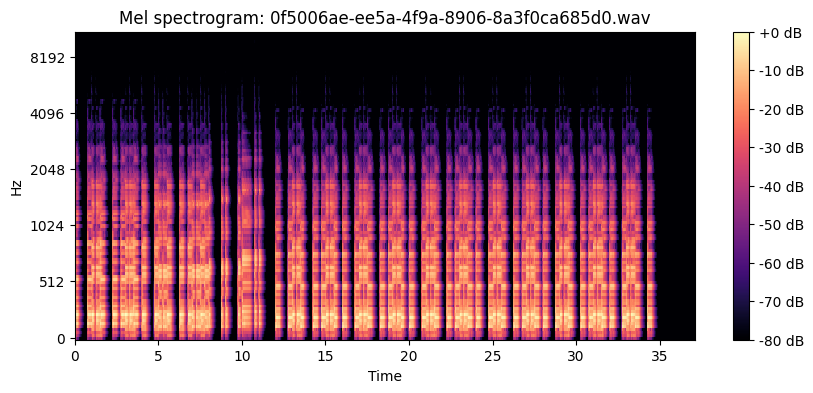

First piece's spectrogram shape: (128, 1598), Num slices: 320
Playing the first slice:
Playing reconstructed full audio from all slices:


In [124]:
dev_test_audio_files = list(Path("./tests").glob('*.wav'))
dev_test_sequences, slice_duration_sec, hop_length = extract_spectrograms(dev_test_audio_files, visualize=True)
sr = 22050  # sample rate, must match what you used

# take first audio file, first slice
first_seq = dev_test_sequences[0] # shape: (num_slices, n_mels)
first_slice_db = first_seq[0]
first_slice_power = librosa.db_to_power(first_slice_db)
y_slice = librosa.feature.inverse.mel_to_audio(first_slice_power, sr=sr, n_fft=2048, hop_length=hop_length)
print("Playing the first slice:")
Audio(y_slice, rate=sr)

# Convert dB back to power
full_spectrogram_db = np.hstack(first_seq)  # shape: (n_mels, total_frames)
full_spectrogram_power = librosa.db_to_power(full_spectrogram_db)
# Reconstruct full waveform
y_full = librosa.feature.inverse.mel_to_audio(full_spectrogram_power, sr=sr, n_fft=2048, hop_length=hop_length)
print("Playing reconstructed full audio from all slices:")
Audio(y_full, rate=sr)

### K-Means Quantization of Features (Encoding Function)

In [125]:
def extract_piano_features(slice_spectrogram, sr=22050, hop_length=512, n_mels=128):
    """
    Extract piano-specific features: pitch, note position, dynamics.
    
    Args:
        slice_spectrogram: (n_mels, frames) mel spectrogram in dB
        
    Returns:
        feature_vector: ~20D array
    """
    features = []
    
    # ========================================
    # 1. PITCH FEATURES
    # ========================================
    
    # Convert mel spectrogram to chroma (12 pitch classes)
    # This captures "what note" regardless of octave
    S_power = librosa.db_to_power(slice_spectrogram)
    chroma = librosa.feature.chroma_stft(S=S_power, sr=sr, hop_length=hop_length, 
                                          n_chroma=12)
    chroma_mean = np.mean(chroma, axis=1)  # (12,) - average pitch content
    features.extend(chroma_mean)
    
    # Dominant pitch class (strongest note)
    dominant_pitch = np.argmax(chroma_mean)
    features.append(dominant_pitch)  # 0-11 (C, C#, D, ..., B)
    
    # Pitch strength (how clear is the pitch?)
    pitch_strength = np.max(chroma_mean) / (np.mean(chroma_mean) + 1e-8)
    features.append(pitch_strength)
    
    # ========================================
    # 2. NOTE POSITION (onset/sustain/release)
    # ========================================
    
    # Spectral flux (how much change from frame to frame)
    # High at onset, low during sustain/release
    if slice_spectrogram.shape[1] > 1:
        flux = np.mean(np.abs(np.diff(slice_spectrogram, axis=1)))
    else:
        flux = 0
    features.append(flux)
    
    # Temporal envelope (energy over time)
    rms_per_frame = np.sqrt(np.mean(S_power, axis=0))
    
    # Is this an onset? (rising energy)
    if len(rms_per_frame) > 1:
        energy_change = rms_per_frame[-1] - rms_per_frame[0]
        features.append(energy_change)  # Positive = attack, negative = decay
    else:
        features.append(0)
    
    # Energy slope (attack vs release)
    if len(rms_per_frame) > 1:
        slope = np.polyfit(np.arange(len(rms_per_frame)), rms_per_frame, 1)[0]
        features.append(slope)
    else:
        features.append(0)
    
    # ========================================
    # 3. DYNAMICS (loud/soft)
    # ========================================
    
    # Overall energy
    rms_mean = np.mean(rms_per_frame)
    features.append(rms_mean)
    
    # Peak energy
    rms_max = np.max(rms_per_frame)
    features.append(rms_max)
    
    # Dynamic range
    features.append(rms_max - np.min(rms_per_frame))
    
    # ========================================
    # 4. SPECTRAL SHAPE (register - high/low)
    # ========================================
    
    # Spectral centroid (brightness - which octave?)
    centroid = np.mean(np.sum(S_power * np.arange(n_mels)[:, None], axis=0) 
                      / (np.sum(S_power, axis=0) + 1e-8))
    features.append(centroid)
    
    return np.array(features)

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

def find_optimal_clusters_silhouette(features, k_range=range(10, 150, 10)):
    """
    Use silhouette score to find optimal clusters.
    Higher score = better defined clusters.
    
    Returns:
        best_k: optimal number of clusters
    """
    silhouette_scores = []
    
    print("Computing silhouette scores...")
    for k in tqdm(k_range):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels, sample_size=5000)  # Sample for speed
        silhouette_scores.append(score)
        print(f"k={k}: silhouette={score:.3f}")
    
    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, silhouette_scores, 'go-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.show()
    
    # Pick k with highest silhouette score
    best_idx = np.argmax(silhouette_scores)
    best_k = list(k_range)[best_idx]
    
    print(f"\nOptimal k: {best_k} (silhouette score: {silhouette_scores[best_idx]:.3f})")
    
    return best_k, silhouette_scores

In [126]:
import numpy as np
from sklearn.cluster import KMeans

def quantize_slices(sequences, n_clusters=290):
    """
    Flatten slices, cluster them via KMeans, and optionally visualize cluster centers.

    Args:
        sequences: list of list of slices from extract_spectrograms
            sequences[i][j] -> slice (n_mels, frames_per_slice)
        n_clusters: number of clusters for KMeans (if None, find optimal number )
    """
    # ========================================
    # Step 1: Extract piano-specific features
    # ========================================
    all_features = []
    all_slices_original = []

    for audio_seq in sequences:
        for slice_ in audio_seq:
            features = extract_piano_features(slice_)  # ~20D
            all_features.append(features)
            all_slices_original.append(slice_)

    all_features = np.array(all_features)
    print(f"Extracted features: {all_features.shape}")  # (n_slices, 20)


    # ========================================
    # (Optional) Step 2: Find optimal number of clusters
    # ========================================
    if n_clusters is None:
        n_clusters, scores = find_optimal_clusters_silhouette(
            all_features, 
            k_range=range(20, 700, 10)
        )
        print(f"Optimal n_cluster: {n_clusters}")

    # ========================================
    # Step 3: Cluster with optimal k
    # ========================================
    print(f"\nClustering with k={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(all_features)

    # ========================================
    # Step 4: Store exemplars
    # ========================================
    sequences_discrete = []
    slice_idx = 0
    
    for audio_seq in sequences:
        discrete_seq = []
        for slice_ in audio_seq:
            # Assign this slice to its cluster
            discrete_seq.append(labels[slice_idx])
            slice_idx += 1
        sequences_discrete.append(discrete_seq)

    # ========================================
    # Step 5: Store exemplars (one real sample per cluster)
    # ========================================
    exemplars = []
    for cluster_id in range(n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        if len(cluster_indices) > 0:
            # Pick closest to center
            cluster_features = all_features[cluster_indices]
            center = kmeans.cluster_centers_[cluster_id]
            distances = np.linalg.norm(cluster_features - center, axis=1)
            exemplar_idx = cluster_indices[np.argmin(distances)]
            exemplars.append(all_slices_original[exemplar_idx])
        else:
            # Empty cluster - use a default
            exemplars.append(all_slices_original[0])

    print(f"✓ Created {len(sequences_discrete)} discrete sequences with {n_clusters} cluster vocabulary!")
    print(f"✓ Stored {len(exemplars)} exemplar samples (one per cluster)")
    
    return sequences_discrete, kmeans, exemplars

### Conversion between Cluster ID and spectrogram / audio (Decoding Function)

In [127]:
def audio_to_cluster_sequence(audio_path, kmeans, slice_sec, hop_length, sr=22050, n_mels=128, n_fft=2048, pad=True):
    # Load audio
    y, _ = librosa.load(audio_path, sr=sr)
    slices, _ = slice_waveform(y, sr=sr, slice_sec=slice_sec,
                               n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, pad=pad)
    
    # Extract features for each slice, then predict cluster ID
    cluster_seq = []
    for slice_ in slices:
        features = extract_piano_features(slice_)  # Extract ~20D features
        cluster_id = kmeans.predict(features.reshape(1, -1))[0]
        cluster_seq.append(cluster_id)
    
    return cluster_seq

def clusters_to_spectrogram(generated_clusters, exemplars, smoothing_sigma=1.0):
    """
    Convert cluster IDs back to Mel spectrogram slices.
    Optionally smooth in time to avoid abrupt jumps (if smoothing_sigma = None, no smoothing)
    """
    slices = [exemplars[cid] for cid in generated_clusters]  # Use real exemplar slices
    # slices = [kmeans.cluster_centers_[cid].reshape(n_mels, frames_per_slice) for cid in generated_clusters]
    S_gen = np.hstack(slices)  # concatenate along time
    # Optional smoothing
    if smoothing_sigma:
        from scipy.ndimage import gaussian_filter1d
        S_gen = gaussian_filter1d(S_gen, sigma=smoothing_sigma, axis=1)
    return S_gen

def spectrogram_to_audio(S_db, sr=22050, n_fft=2048, hop_length=512):
    S_power = librosa.db_to_power(S_db)
    y = librosa.feature.inverse.mel_to_audio(S_power, sr=sr, n_fft=n_fft, hop_length=hop_length, n_iter=60)
    return y

## Training Variable-Order HMM (VOHMM)

In [128]:
import numpy as np
from collections import defaultdict, Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

class VOHMM:
    def __init__(self, n_hidden=16, order=2, verbose=True):
        self.n_hidden = n_hidden
        self.order = order
        self.verbose = verbose

        # Transition table: {history_length: {history_tuple: Counter(next_hidden)}}
        self.transitions = defaultdict(lambda: defaultdict(Counter))
        # Emission table: list of Counters for each hidden state
        self.emissions = [Counter() for _ in range(n_hidden)]
        # Cluster vocabulary
        self.cluster_vocab = None
        self.cluster_to_idx = None

    def fit(self, sequences):
        """
        Fit VOHMM to sequences of cluster IDs.
        sequences: list of lists of cluster IDs
        """
        # Build cluster vocabulary
        self.cluster_vocab = sorted(set(c for seq in sequences for c in seq))
        self.cluster_to_idx = {c:i for i,c in enumerate(self.cluster_vocab)}

        # Encode sequences as indices
        sequences_idx = [[self.cluster_to_idx[c] for c in seq] for seq in sequences]

        # Randomly assign hidden states
        hidden_assignments = []
        if self.verbose:
            print(f"Assigning initial random hidden states to {len(sequences_idx)} sequences...")
        for seq in tqdm(sequences_idx, desc="Initializing hidden states"):
            hidden_seq = np.random.choice(self.n_hidden, size=len(seq))
            hidden_assignments.append(hidden_seq)

        # Count emissions
        if self.verbose:
            print("Counting emissions...")
        for seq, hidden_seq in tqdm(zip(sequences_idx, hidden_assignments), total=len(sequences_idx), desc="Counting emissions"):
            for obs, h in zip(seq, hidden_seq):
                self.emissions[h][obs] += 1

        # Count transitions for all history lengths
        if self.verbose:
            print(f"Counting variable-order transitions (order={self.order})...")
        for hidden_seq in tqdm(hidden_assignments, desc="Counting transitions"):
            for t in range(1, len(hidden_seq)):
                max_len = min(self.order, t)
                for l in range(1, max_len+1):
                    history = tuple(hidden_seq[t-l:t])
                    next_h = hidden_seq[t]
                    self.transitions[l][history][next_h] += 1

        if self.verbose:
            print("VOHMM training complete.")

    def plot_emissions(self, normalize=True, cmap='viridis'):
        """
        Visualize emissions of all hidden states as a heatmap.

        Args:
            normalize: if True, each hidden state's emissions are normalized to sum=1
            cmap: matplotlib colormap
        """
        vocab_size = len(self.cluster_vocab)
        emission_matrix = np.zeros((self.n_hidden, vocab_size))

        for h, counter in enumerate(self.emissions):
            for c_idx, cluster in enumerate(self.cluster_vocab):
                emission_matrix[h, c_idx] = counter[cluster]
            if normalize and emission_matrix[h].sum() > 0:
                emission_matrix[h] /= emission_matrix[h].sum()

        plt.figure(figsize=(12,6))
        plt.imshow(emission_matrix, aspect='auto', origin='lower', cmap=cmap)
        plt.colorbar(label='Emission Probability' if normalize else 'Counts')
        plt.xlabel("Cluster ID")
        plt.ylabel("Hidden State")
        plt.title("Emission Probabilities of Hidden States")
        plt.xticks(ticks=np.arange(vocab_size), labels=self.cluster_vocab, rotation=90)
        plt.yticks(ticks=np.arange(self.n_hidden))
        plt.tight_layout()
        plt.show()

    def generate(self, n_steps=32, alpha=0.7, local_hidden_sequence=None, start_hidden=None):
        """
        Generate cluster sequence from VOHMM.
        alpha: weight for local sequence
        """
        generated_clusters = []

        # Initialize hidden history
        if start_hidden is None:
            hidden_history = [np.random.choice(self.n_hidden)] * self.order
        else:
            hidden_history = list(start_hidden)

        for t in range(n_steps):
            # --- Determine next hidden state ---
            next_h = None
            found = False
            for backoff in range(self.order, 0, -1):
                history_tuple = tuple(hidden_history[-backoff:])
                global_counts = self.transitions[backoff].get(history_tuple, {})

                # Local counts
                local_counts = Counter()
                if local_hidden_sequence is not None and len(local_hidden_sequence) >= backoff:
                    for i in range(len(local_hidden_sequence)-backoff):
                        if tuple(local_hidden_sequence[i:i+backoff]) == history_tuple:
                            next_state = local_hidden_sequence[i+backoff]
                            local_counts[next_state] += 1

                all_choices = sorted(set(global_counts.keys()) | set(local_counts.keys()))
                if not all_choices:
                    continue  # backoff

                probs = []
                for h in all_choices:
                    g_prob = global_counts[h]/sum(global_counts.values()) if h in global_counts else 0
                    l_prob = local_counts[h]/sum(local_counts.values()) if h in local_counts else 0
                    probs.append(alpha*l_prob + (1-alpha)*g_prob)
                probs = np.array(probs)
                probs /= probs.sum()
                next_h = np.random.choice(all_choices, p=probs)
                found = True
                break

            if not found:
                next_h = np.random.choice(self.n_hidden)
                if self.verbose:
                    print(f"Step {t}: No matching history, picked random hidden state {next_h}")

            hidden_history.append(next_h)

            # --- Sample observation from emission ---
            emission_counter = self.emissions[next_h]
            obs_choices = list(emission_counter.keys())
            counts = np.array([emission_counter[c] for c in obs_choices])
            probs_obs = counts / counts.sum()
            next_obs = np.random.choice(obs_choices, p=probs_obs)
            generated_clusters.append(next_obs)

            # Visualization / verbose
            if self.verbose:
                print(f"Step {t}: hidden={next_h}, obs={next_obs}")

        return generated_clusters

    def infer_hidden_sequence(self, observed_sequence):
        """
        Simple Viterbi-like decoding using max emission probability (not true HMM)
        """
        hidden_seq = []
        for obs in observed_sequence:
            best_h = np.argmax([self.emissions[h][obs] if obs in self.emissions[h] else 0 for h in range(self.n_hidden)])
            hidden_seq.append(best_h)
        return hidden_seq


In [138]:
n_clusters=500
n_states=20
verbose=False
audio_files = list(TRAIN_DIR.glob('*.wav'))
sequences, slice_sec, hop_length = extract_spectrograms(audio_files, note_fraction=0.25, visualize=verbose)
sequences_discrete, kmeans, exemplars = quantize_slices(sequences, n_clusters=n_clusters)

vohmm = VOHMM(n_hidden=n_states, order=50, verbose=verbose)
vohmm.fit(sequences_discrete)
# vohmm.plot_emissions()


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Extracted features: (21932, 21)

Clustering with k=500...
✓ Created 73 discrete sequences with 500 cluster vocabulary!
✓ Stored 500 exemplar samples (one per cluster)


Counting transitions: 100%|██████████| 73/73 [00:02<00:00, 32.86it/s]


## Prediction with VOHMM

In [139]:
audio_path = "./tests/0f5006ae-ee5a-4f9a-8906-8a3f0ca685d0.wav"
print(f"prime audio file: {audio_path}")
Audio(audio_path, rate=22050)


prime audio file: ./tests/0f5006ae-ee5a-4f9a-8906-8a3f0ca685d0.wav


cluster sequence of the test file (320 slices in total): [43, 43, 43, 43, 181, 45, 230, 443, 43, 445, 153, 445, 450, 445, 443, 43, 43, 101, 75, 230, 443, 443, 43, 320, 443, 43, 445, 445, 266, 450, 12, 445, 43, 43, 402, 445, 450, 12, 329, 51, 223, 445, 450, 12, 219, 183, 219, 211, 445, 450, 12, 329, 238, 223, 445, 450, 12, 12, 153, 450, 266, 219, 183, 219, 126, 445, 450, 12, 219, 419, 419, 419, 282, 45, 45, 368, 419, 92, 419, 419, 87, 195, 45, 56, 419, 419, 156, 160, 160, 160, 160, 242, 264, 361, 156, 452, 242, 160, 169, 45, 45, 45, 45, 172, 61, 475, 166, 379, 282, 223, 475, 61, 445, 467, 153, 450, 43, 61, 166, 475, 206, 121, 263, 475, 61, 166, 379, 135, 61, 272, 445, 266, 445, 445, 61, 166, 166, 178, 475, 61, 166, 166, 438, 344, 178, 61, 25, 445, 153, 445, 445, 475, 61, 166, 166, 418, 455, 310, 61, 475, 166, 178, 61, 379, 445, 266, 445, 450, 379, 475, 166, 379, 178, 61, 475, 166, 379, 181, 263, 475, 475, 445, 445, 266, 450, 43, 475, 475, 166, 379, 169, 498, 61, 61, 166, 492, 479, 61, 1

/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

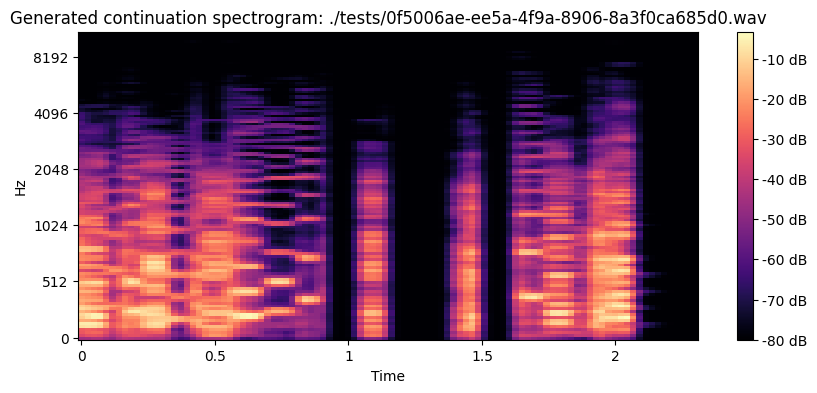

In [142]:
# Step 1: map to cluster sequence
cluster_seq = audio_to_cluster_sequence(audio_path, kmeans, slice_sec, hop_length)
print(f"cluster sequence of the test file ({len(cluster_seq)} slices in total): {[int(x) for x in cluster_seq]}")

# Step 2: generate continuation cluster IDs
last_hidden = vohmm.infer_hidden_sequence(cluster_seq)[-vohmm.order:]
generated_clusters = vohmm.generate(start_hidden=last_hidden, n_steps=20, alpha=0.1)
print(f"generated continuation (cluster IDs): {generated_clusters}")

# Step 3: convert clusters to spectrogram
frames_per_slice = int(slice_sec * sr / hop_length)
S_gen = clusters_to_spectrogram(generated_clusters, exemplars, smoothing_sigma=0.8)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_gen, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title(f"Generated continuation spectrogram: {audio_path}")
plt.show()

# Step 4: reconstruct audio
y_gen = spectrogram_to_audio(S_gen, sr=sr, n_fft=2048, hop_length=hop_length)
# Listen to generated continuation
from IPython.display import Audio
Audio(y_gen, rate=sr)

## Evaluation

In [ ]:
def audio_to_midi(audio, method='piptrack', sr=22050, hop_length=512, 
                  fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'),
                  min_note_duration=0.1):
    """
    Convert audio to MIDI using librosa.
    
    Args:
        audio_path: path to audio file
        method: 'piptrack', 'yin', or 'onset' for different pitch detection methods
        sr: sample rate
        hop_length: hop length for STFT
        fmin, fmax: frequency range for pitch detection
        min_note_duration: minimum note length in seconds (filters out very short notes)
    
    Returns:
        pretty_midi.PrettyMIDI object
    """
    # Load audio
    y=audio
    
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0, is_drum=False, name="Piano")
    
    if method == 'piptrack':
        # Method 1: Piptrack (good for general use)
        pitches, magnitudes = librosa.piptrack(
            y=y, sr=sr, hop_length=hop_length, 
            fmin=fmin, fmax=fmax, threshold=0.1
        )
        
        # Extract pitch track
        pitch_track = []
        for frame_idx in range(pitches.shape[1]):
            index = magnitudes[:, frame_idx].argmax()
            pitch = pitches[index, frame_idx]
            pitch_track.append(pitch)
        
    elif method == 'yin':
        # Method 2: YIN algorithm (better for monophonic, cleaner pitch)
        pitch_track = librosa.yin(
            y, fmin=fmin, fmax=fmax, sr=sr, 
            hop_length=hop_length, frame_length=hop_length*4
        )
        
    elif method == 'onset':
        # Method 3: Onset-based with spectral peak
        onset_frames = librosa.onset.onset_detect(
            y=y, sr=sr, hop_length=hop_length, backtrack=True
        )
        
        # Get spectrogram
        S = np.abs(librosa.stft(y, hop_length=hop_length))
        freqs = librosa.fft_frequencies(sr=sr)
        
        # Extract pitch at each onset
        pitch_track = np.zeros(S.shape[1])
        for onset_frame in onset_frames:
            if onset_frame < S.shape[1]:
                # Find peak frequency
                spectrum = S[:, onset_frame]
                peak_bin = np.argmax(spectrum)
                pitch_track[onset_frame] = freqs[peak_bin]
                
                # Forward fill until next onset
                next_onset = onset_frames[np.where(onset_frames > onset_frame)[0]]
                if len(next_onset) > 0:
                    pitch_track[onset_frame:next_onset[0]] = freqs[peak_bin]
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Convert pitch track to MIDI notes
    current_note = None
    note_start = None
    note_start_frame = None
    
    for frame_idx, pitch in enumerate(pitch_track):
        time = librosa.frames_to_time(frame_idx, sr=sr, hop_length=hop_length)
        
        if pitch > 0:  # Valid pitch detected
            midi_note = int(np.round(librosa.hz_to_midi(pitch)))
            midi_note = np.clip(midi_note, 21, 108)  # Piano range
            
            # Start new note or continue current
            if current_note is None:
                # Start new note
                current_note = midi_note
                note_start = time
                note_start_frame = frame_idx
            elif abs(current_note - midi_note) > 0.5:  # Pitch changed (allow small variations)
                # End previous note if long enough
                if time - note_start >= min_note_duration:
                    note = pretty_midi.Note(
                        velocity=80, 
                        pitch=current_note, 
                        start=note_start, 
                        end=time
                    )
                    instrument.notes.append(note)
                
                # Start new note
                current_note = midi_note
                note_start = time
                note_start_frame = frame_idx
        else:
            # Silence detected - end current note
            if current_note is not None:
                if time - note_start >= min_note_duration:
                    note = pretty_midi.Note(
                        velocity=80, 
                        pitch=current_note, 
                        start=note_start, 
                        end=time
                    )
                    instrument.notes.append(note)
                current_note = None
    
    # End final note
    if current_note is not None:
        final_time = librosa.frames_to_time(len(pitch_track), sr=sr, hop_length=hop_length)
        if final_time - note_start >= min_note_duration:
            note = pretty_midi.Note(
                velocity=80, 
                pitch=current_note, 
                start=note_start, 
                end=final_time
            )
            instrument.notes.append(note)
    
    midi.instruments.append(instrument)
    print(f"✓ Generated {len(instrument.notes)} MIDI notes using {method} method")
    
    return midi


# Usage examples:
# Method 1: Piptrack (balanced)
midi1 = audio_to_midi(y_gen, method='piptrack')

# Method 2: YIN (best for clean monophonic)
midi2 = audio_to_midi(y_gen, method='yin')

# Method 3: Onset-based (good for percussive/rhythmic)
midi3 = audio_to_midi(y_gen, method='onset')

# soundfont = "UprightPianoKW-small-20190703.sf2"
# #play midi
# audio = midi3.fluidsynth(fs=22050, sf2_path=soundfont)
# Audio(audio, rate=22050)

✓ Generated 6 MIDI notes using piptrack method
✓ Generated 10 MIDI notes using yin method
✓ Generated 11 MIDI notes using onset method


In [133]:
def spectrogram_to_midi(S_gen, sr=22050, hop_length=512, n_mels=128, 
                        fmin=20, fmax=8000, program=0):
    """
    Convert a mel spectrogram to MIDI using onset detection and peak frequency.
    
    Args:
        S_gen: Mel spectrogram (n_mels, total_frames)
        sr: Sample rate
        hop_length: Hop length used for spectrogram
        n_mels: Number of mel bins
        fmin, fmax: Frequency range for mel scale
        program: MIDI program number (0 = Acoustic Grand Piano)
    
    Returns:
        pretty_midi.PrettyMIDI object
    """
    mel_freqs = librosa.mel_frequencies(n_mels=n_mels, fmin=fmin, fmax=fmax)
    
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program, is_drum=False)
    
    print(f"Spectrogram shape: {S_gen.shape}")
    
    # Find onsets using librosa
    onset_frames = librosa.onset.onset_detect(
        y=None, 
        sr=sr, 
        onset_envelope=librosa.onset.onset_strength(S=S_gen, sr=sr), 
        hop_length=hop_length
    )
    
    print(f"Detected {len(onset_frames)} onsets")
    
    for i, onset_frame in enumerate(onset_frames):
        # Determine note duration (until next onset or end)
        if i < len(onset_frames) - 1:
            end_frame = onset_frames[i + 1]
        else:
            end_frame = S_gen.shape[1]
        
        # Extract spectrum at this onset
        spec_slice = S_gen[:, onset_frame:end_frame]
        
        # Find peak frequency (weighted average for stability)
        energy_per_bin = np.mean(spec_slice, axis=1)
        peak_mel_bin = np.argmax(energy_per_bin)
        peak_freq = mel_freqs[peak_mel_bin]
        
        if peak_freq > 0:
            # Convert to MIDI note
            midi_note = int(np.round(librosa.hz_to_midi(peak_freq)))
            midi_note = np.clip(midi_note, 21, 108)  # Piano range
            
            # Create note with proper timing
            start_time = librosa.frames_to_time(onset_frame, sr=sr, hop_length=hop_length)
            end_time = librosa.frames_to_time(end_frame, sr=sr, hop_length=hop_length)
            
            note = pretty_midi.Note(
                velocity=80, 
                pitch=midi_note, 
                start=start_time, 
                end=end_time
            )
            instrument.notes.append(note)
    
    midi.instruments.append(instrument)
    print(f"✓ Generated {len(instrument.notes)} MIDI notes")
    
    return midi


# Usage:
midi = spectrogram_to_midi(S_gen, sr=22050, hop_length=512, n_mels=128)

# soundfont = "UprightPianoKW-small-20190703.sf2"
# # midi = audio_to_midi_librosa(y_gen, sr=22050, hop_length=512, onset_threshold=0.5)
# #play midi
# audio = midi.fluidsynth(fs=22050, sf2_path=soundfont)
# Audio(audio, rate=22050)

Spectrogram shape: (128, 100)
Detected 11 onsets
✓ Generated 11 MIDI notes


In [134]:
def cardinality_score(predicted_midi, ground_truth_midi):
    """
    Calculate cardinality score: ratio of correctly predicted notes.

    Args:
        predicted_midi: Predicted pretty_midi.PrettyMIDI
        ground_truth_midi: Ground truth pretty_midi.PrettyMIDI

    Returns:
        score: 0 to 1, higher is better
    """
    try:
        pred_notes = predicted_midi.instruments[0].notes if predicted_midi.instruments else []
        gt_notes = ground_truth_midi.instruments[0].notes if ground_truth_midi.instruments else []

        if len(gt_notes) == 0:
            return 0.0

        # Count matching notes (within tolerance)
        matches = 0
        for pred_note in pred_notes:
            for gt_note in gt_notes:
                if abs(pred_note.pitch - gt_note.pitch) <= 1:  # Within 1 semitone
                    matches += 1
                    break

        return min(matches / len(gt_notes), 1.0)
    except:
        return 0.0

def pitch_accuracy(predicted_midi, ground_truth_midi):
    """
    Calculate average pitch accuracy of predicted notes.

    Args:
        predicted_midi: Predicted pretty_midi.PrettyMIDI
        ground_truth_midi: Ground truth pretty_midi.PrettyMIDI

    Returns:
        accuracy: 0 to 1, higher is better
    """
    try:
        pred_notes = predicted_midi.instruments[0].notes if predicted_midi.instruments else []
        gt_notes = ground_truth_midi.instruments[0].notes if ground_truth_midi.instruments else []

        if len(pred_notes) == 0 or len(gt_notes) == 0:
            return 0.0

        accuracies = []
        for pred_note in pred_notes:
            # Find closest ground truth note
            min_pitch_diff = min(abs(pred_note.pitch - gt_note.pitch) for gt_note in gt_notes)
            # Accuracy decreases with pitch difference
            acc = max(0, 1 - min_pitch_diff / 12)  # Normalize by octave
            accuracies.append(acc)

        return np.mean(accuracies) if accuracies else 0.0
    except:
        return 0.0

In [146]:
import os
import glob
import numpy as np
import pandas as pd
from pathlib import Path

def evaluate_test_set(test_audio_dir, test_midi_dir, kmeans, exemplars, 
                     slice_sec, hop_length, sr=22050, n_mels=128, n_fft=2048, method= 'onset', from_audio = False):
    """
    Evaluate HMM continuation on entire test set.
    
    Args:
        test_audio_dir: Directory containing test audio files (.wav)
        test_midi_dir: Directory containing ground truth MIDI continuations
        kmeans: Trained KMeans model
        exemplars: Cluster exemplars for reconstruction
        slice_sec: Slice duration in seconds
        hop_length: STFT hop length
        sr: Sample rate
        n_mels: Number of mel bins
        n_fft: FFT size
    
    Returns:
        results_df: DataFrame with per-file results
        summary: Dict with mean and std statistics
    """
    
    # Find all test audio files
    audio_files = sorted(glob.glob(os.path.join(test_audio_dir, "*.wav")))
    
    print(f"Found {len(audio_files)} test audio files")
    
    results = []
    
    for audio_path in audio_files:
        # Get corresponding MIDI file
        audio_filename = Path(audio_path).stem
        midi_filename = f"{audio_filename}_continuation.mid"
        midi_path = os.path.join(test_midi_dir, midi_filename)
        
        # Skip if MIDI ground truth doesn't exist
        if not os.path.exists(midi_path):
            print(f"Warning: Ground truth MIDI not found for {audio_filename}, skipping...")
            continue
        
        print(f"\nProcessing: {audio_filename}")
        
        try:
            # Load ground truth MIDI
            midi_gt = pretty_midi.PrettyMIDI(midi_path)
            
            # Step 1: Map audio to cluster sequence
            # Step 1: map to cluster sequence
            cluster_seq = audio_to_cluster_sequence(audio_path, kmeans, slice_sec, hop_length)
            
            # Step 2: generate continuation cluster IDs
            last_hidden = vohmm.infer_hidden_sequence(cluster_seq)[-vohmm.order:]
            generated_clusters = vohmm.generate(start_hidden=last_hidden, n_steps=32, alpha=0.1)

            # Step 3: Convert clusters to spectrogram
            frames_per_slice = int(slice_sec * sr / hop_length)
            S_gen = clusters_to_spectrogram(generated_clusters, exemplars, smoothing_sigma=0.8)
            y_gen = spectrogram_to_audio(S_gen, sr=sr, n_fft=2048, hop_length=hop_length)

            # Step 4: Convert to MIDI
            if from_audio:
                midi_pred = audio_to_midi(y_gen, method=method)
            else:   
                midi_pred = spectrogram_to_midi(
                    S_gen, sr=sr, hop_length=hop_length, n_mels=n_mels)
            
            
            # Step 5: Evaluate
            pitch = pitch_accuracy(midi_pred, midi_gt)
            cardinality = cardinality_score(midi_pred, midi_gt)
            
            # Count notes
            pred_notes = midi_pred.instruments[0].notes if midi_pred.instruments else []
            gt_notes = midi_gt.instruments[0].notes if midi_gt.instruments else []
            
            # Store results
            results.append({
                'filename': audio_filename,
                'pitch_accuracy': pitch,
                'cardinality_score': cardinality,
                'num_pred_notes': len(pred_notes),
                'num_gt_notes': len(gt_notes),
                'note_count_ratio': len(pred_notes) / len(gt_notes) if len(gt_notes) > 0 else 0
            })
            
            print(f"  Pitch Accuracy: {pitch:.3f}")
            print(f"  Cardinality Score: {cardinality:.3f}")
            print(f"  Notes: {len(pred_notes)} pred vs {len(gt_notes)} gt")
            
        except Exception as e:
            print(f"  Error processing {audio_filename}: {e}")
            continue
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    if len(results_df) == 0:
        print("\nNo files successfully processed!")
        return None, None
    
    # Calculate summary statistics
    summary = {
        'pitch_accuracy_mean': results_df['pitch_accuracy'].mean(),
        'pitch_accuracy_std': results_df['pitch_accuracy'].std(),
        'cardinality_score_mean': results_df['cardinality_score'].mean(),
        'cardinality_score_std': results_df['cardinality_score'].std(),
        'note_count_ratio_mean': results_df['note_count_ratio'].mean(),
        'note_count_ratio_std': results_df['note_count_ratio'].std(),
        'num_files': len(results_df)
    }
    
    return results_df, summary


# Usage:
test_audio_dir = "./normalized_dataset/test"
test_midi_dir = "./normalized_dataset/test/continuation_midi"

results_df, summary = evaluate_test_set(
    test_audio_dir=test_audio_dir,
    test_midi_dir=test_midi_dir,
    kmeans=kmeans,
    exemplars=exemplars,
    slice_sec=slice_sec,
    hop_length=hop_length,
    sr=22050,
    n_mels=128,
    n_fft=2048,
    method='yin', # 'piptrack', 'yin', or 'onset'
    from_audio=True
)

# Print summary
print("\n" + "="*60)
print("EVALUATION SUMMARY")
print("="*60)
print(f"Number of test files: {summary['num_files']}")
print(f"\nPitch Accuracy: {summary['pitch_accuracy_mean']:.3f} ± {summary['pitch_accuracy_std']:.3f}")
print(f"Cardinality Score: {summary['cardinality_score_mean']:.3f} ± {summary['cardinality_score_std']:.3f}")
print(f"Note Count Ratio: {summary['note_count_ratio_mean']:.3f} ± {summary['note_count_ratio_std']:.3f}")

# Save detailed results
results_df.to_csv('test_results_detailed.csv', index=False)
print(f"\nDetailed results saved to: test_results_detailed.csv")

# Display results table
print("\n" + "="*60)
print("PER-FILE RESULTS")
print("="*60)
print(results_df.to_string(index=False))

Found 28 test audio files

Processing: 0776e078-d0ef-4d66-aacd-fdc10b9c12be


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 18 MIDI notes using yin method
  Pitch Accuracy: 0.204
  Cardinality Score: 0.200
  Notes: 18 pred vs 10 gt

Processing: 1050d971-1dab-4df4-929c-3fffe2cd758a


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.194
  Cardinality Score: 0.100
  Notes: 15 pred vs 10 gt

Processing: 21a9f82f-0064-4f09-ad19-15ef93a040a5


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 12 MIDI notes using yin method
  Pitch Accuracy: 0.431
  Cardinality Score: 0.200
  Notes: 12 pred vs 15 gt

Processing: 21ef4bc9-db9d-48e2-b91b-3b4089bf5877


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 18 MIDI notes using yin method
  Pitch Accuracy: 0.694
  Cardinality Score: 0.800
  Notes: 18 pred vs 15 gt

Processing: 2276524b-070e-41de-abd4-ef8869c9adc6


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 14 MIDI notes using yin method
  Pitch Accuracy: 0.792
  Cardinality Score: 0.800
  Notes: 14 pred vs 10 gt

Processing: 2c761eb9-f2fa-4699-a5f0-5aab57497866


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 16 MIDI notes using yin method
  Pitch Accuracy: 0.500
  Cardinality Score: 0.500
  Notes: 16 pred vs 10 gt

Processing: 2c853657-3957-4cd9-93d7-5cbf1c36f923


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 16 MIDI notes using yin method
  Pitch Accuracy: 0.198
  Cardinality Score: 0.105
  Notes: 16 pred vs 19 gt

Processing: 36a979d0-1ebb-4b66-947f-7e1432dd7a4c


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 14 MIDI notes using yin method
  Pitch Accuracy: 0.244
  Cardinality Score: 0.120
  Notes: 14 pred vs 25 gt

Processing: 45726be2-49be-40a2-ac6b-5bcc1820c20c


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.533
  Cardinality Score: 0.100
  Notes: 15 pred vs 20 gt

Processing: 4d2779a2-3ecd-42b0-9908-3bd443a8153d


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 13 MIDI notes using yin method
  Pitch Accuracy: 0.897
  Cardinality Score: 0.667
  Notes: 13 pred vs 15 gt

Processing: 4db351ff-aea1-4040-bbf7-d4852c99f1d0


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 14 MIDI notes using yin method
  Pitch Accuracy: 0.613
  Cardinality Score: 0.250
  Notes: 14 pred vs 20 gt

Processing: 56ea0bf1-f666-4827-b4df-392d4abcb39d


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.567
  Cardinality Score: 0.050
  Notes: 15 pred vs 20 gt

Processing: 5b17365a-30ca-40db-9bf3-2b1613c77e76


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.522
  Cardinality Score: 0.238
  Notes: 15 pred vs 21 gt

Processing: 668d8c96-4a58-43cd-b141-9c46f8ea25f4


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 18 MIDI notes using yin method
  Pitch Accuracy: 0.269
  Cardinality Score: 0.091
  Notes: 18 pred vs 11 gt

Processing: 6a5c8eee-0c81-4eaa-89d1-5bf666293571


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 18 MIDI notes using yin method
  Pitch Accuracy: 0.144
  Cardinality Score: 0.000
  Notes: 18 pred vs 17 gt

Processing: 7a4b6f4c-2834-4db4-8086-ce22ffd30355


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 19 MIDI notes using yin method
  Pitch Accuracy: 0.487
  Cardinality Score: 0.300
  Notes: 19 pred vs 20 gt

Processing: 7b3165bf-d6c3-4c29-bee0-74d79c96e13e


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 18 MIDI notes using yin method
  Pitch Accuracy: 0.213
  Cardinality Score: 0.065
  Notes: 18 pred vs 31 gt

Processing: 7d83865a-1d0e-41ad-b4a8-ec76cc5bcf8c


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.589
  Cardinality Score: 0.545
  Notes: 15 pred vs 11 gt

Processing: 9d395c06-703c-4c83-b3ac-1c4e4173bfc6


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 13 MIDI notes using yin method
  Pitch Accuracy: 0.250
  Cardinality Score: 0.038
  Notes: 13 pred vs 26 gt

Processing: b94564f2-9723-4aac-b832-e6ac121430cd


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.506
  Cardinality Score: 0.385
  Notes: 15 pred vs 13 gt

Processing: d00564c5-0a59-451d-8464-a69e692f3def


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 18 MIDI notes using yin method
  Pitch Accuracy: 0.417
  Cardinality Score: 0.273
  Notes: 18 pred vs 11 gt

Processing: d2ff6f0a-2ad0-4c70-8358-7ce6993a30c9


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 14 MIDI notes using yin method
  Pitch Accuracy: 0.530
  Cardinality Score: 0.400
  Notes: 14 pred vs 10 gt

Processing: d42c9e96-a8d6-466f-9056-9f019ef0ff5f


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 17 MIDI notes using yin method
  Pitch Accuracy: 0.755
  Cardinality Score: 0.786
  Notes: 17 pred vs 14 gt

Processing: e727167a-6101-4551-bc5e-83e34cf86c58


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 16 MIDI notes using yin method
  Pitch Accuracy: 0.141
  Cardinality Score: 0.067
  Notes: 16 pred vs 15 gt

Processing: ef0368ce-6215-4257-a57b-4791930f4cec


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 19 MIDI notes using yin method
  Pitch Accuracy: 0.500
  Cardinality Score: 0.636
  Notes: 19 pred vs 11 gt

Processing: ef1c3b2b-e616-46df-ac92-addc2e5a73bc


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 16 MIDI notes using yin method
  Pitch Accuracy: 0.344
  Cardinality Score: 0.167
  Notes: 16 pred vs 18 gt

Processing: f96a15cb-4c5b-401b-9ef5-7e293c467c61


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 15 MIDI notes using yin method
  Pitch Accuracy: 0.111
  Cardinality Score: 0.000
  Notes: 15 pred vs 16 gt

Processing: fd12d327-304f-43a6-b290-c77ab07d5e96


/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
/Users/ling/Desktop/GT/6201AudioContentAnalysis/6201PatternForPrediction/pfp/lib/python3.12/site-packages/librosa/co

✓ Generated 19 MIDI notes using yin method
  Pitch Accuracy: 0.355
  Cardinality Score: 0.500
  Notes: 19 pred vs 12 gt

EVALUATION SUMMARY
Number of test files: 28

Pitch Accuracy: 0.428 ± 0.214
Cardinality Score: 0.299 ± 0.258
Note Count Ratio: 1.114 ± 0.392

Detailed results saved to: test_results_detailed.csv

PER-FILE RESULTS
                            filename  pitch_accuracy  cardinality_score  num_pred_notes  num_gt_notes  note_count_ratio
0776e078-d0ef-4d66-aacd-fdc10b9c12be        0.203704           0.200000              18            10          1.800000
1050d971-1dab-4df4-929c-3fffe2cd758a        0.194444           0.100000              15            10          1.500000
21a9f82f-0064-4f09-ad19-15ef93a040a5        0.430556           0.200000              12            15          0.800000
21ef4bc9-db9d-48e2-b91b-3b4089bf5877        0.694444           0.800000              18            15          1.200000
2276524b-070e-41de-abd4-ef8869c9adc6        0.791667           0.80